# PREDIKCIJA POGODAKA U NBA-u

Cilj ovog rada je replicirati rezultate dobivene u članku "Predicting NBA Shots" (http://cs229.stanford.edu/proj2017/final-reports/5132133.pdf) Brett-a Meehan-a sa Sveučilišta u Stanfordu. <br /> 

Autor članka razmatra problem predikcije uspješnosti pogotka u košarci na temelju podataka o pogodcima igrača u NBA-u. Implementirani su algoritmi logističke regresije, SVM-a, naivnog Bayesovog postupka, neuralnih mreža, slučajnih šuma te boosting-a. Pokazano je kako na ograničenom skupu informacija najbolju predikciju radi algoritam boosting.

Vrsta istraživanja provedena u navedenom članku prema:
- **SVRSI** je primijenjeno istraživanje zato što je provedeno radi stvaranja praktičnog znanstvenog znanja, tj. znanja o predikciji uspješnosti pogotka u košarci. To znanje bi u praksi mogli koristiti treneri košarkaških timova.

- **IZVORU INFORMACIJA** je sekundarno istraživanje zato što se podaci temelje na javno dostupnim podacima prikupljenima iz utakmica.

- **VREMENU PROVEDBE** je studija presjeka ili sinkrono istraživanje zato što se koristi za promatranje pojava u određenom trenutku, tj. promatra se konkretni pogodak u košarkaškoj utakmici.

- **NAČINU PRIKUPLJANJA PODATAKA** je dokumentarno istraživanje zato što se koristi pregled postojećih izvora informacija. Korišten je već postojeći dataset.

- **VRSTI KORIŠTENIH PODATAKA** je kvantitativno istraživanje zato što su podaci prikupljeno kvantitativno i koriste se matematički, statistički i računalno potpomognuti alati za njihovo mjerenje.

- **STUPNJU MANIPULACIJE VARIJABLAMA** je promatračko istraživanje zato što se analizira fenomen u njegovom prirodnom kontekstu. Istraživač ne intervenira izravno, već ograničava svoje sudjelovanje na mjerenje varijabli potrebnih za istraživanje.

- **DUBINI ZAKLJUČKA** je istraživačko istraživanje zato što se istražuje nešto što još nije dobro shvaćeno ili dobro istraženo. 

- **VRSTI ZAKLJUČKA** je deduktivno istraživanje zato što se znanje generira iz općenitih podataka iz kojih želimo zaključiti nešto specifično. Općeniti podaci su podaci o nekoj utakmici, a specifični podaci do kojih želimo doći su podaci o uspješnosti košarkaških pogodaka.

Metode prikupljanja podataka koji su korišteni u članku:
- **DOKUMENTARNO ISTRAŽIVANJE:**
    - korišten je pisani izvor podataka
    - podaci su preuzeti s web stranice
    - podaci su javno dostupni
- **OPSERVACIJSKO ISTRAŽIVANJE:**
    - utakmice su promatrane onako kako se uobičajeno događaju, a ne onako kako bi se dogodile u umjetno stvorenim uvjetima


Podaci su prikupljeni prema pravilima istraživačke etike:
- nitko nije pretrpio štetu kao rezultat sudjelovanja u istraživanju
- podaci nisu namješteni, već su javno dostupni službeni podaci s utakmica

# 1. Učitavanje podataka
U radu je korišten dataset sa Kaggle-a koji sadrži podatke o pogodcima NBA igrača iz sezone 2014./2015. Prvi korak je importanje potrebnih biblioteka i učitavanje navedenih podataka iz lokalno pohranjene csv datoteke.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('shot_logs.csv')

# 2. Pregled podataka

Dataset se sastoji od 128 069 redaka (n-torki) i 21 stupca (značajki):

In [3]:
dataset.shape

(128069, 21)

Ispisat ćemo nekoliko redaka kako bi vidjeli koje značajke se nalaze u datasetu i primjere njihovih vrijednosti:

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
dataset.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## 2.1 Značajke:

In [5]:
attributes = dataset.columns.values

for one in attributes:
    print(one)

GAME_ID
MATCHUP
LOCATION
W
FINAL_MARGIN
SHOT_NUMBER
PERIOD
GAME_CLOCK
SHOT_CLOCK
DRIBBLES
TOUCH_TIME
SHOT_DIST
PTS_TYPE
SHOT_RESULT
CLOSEST_DEFENDER
CLOSEST_DEFENDER_PLAYER_ID
CLOSE_DEF_DIST
FGM
PTS
player_name
player_id


Pojašnjenja značajki:
 - GAME_ID: jedinstveni identifikator utakmice
 - MATCHUP: vrijeme utakmice i oznaka koji tim igra kod kojeg tima
 - LOCATION: A (away) ili H (home)
 - W: W (win) ili L (loss)
 - FINAL_MARGIN: za koliko bodova je pobijedio ili izgubio tim igrača  
 - SHOT_NUMBER: redni broj pogotka igrača u utakmici
 - PERIOD: četvrtina utakmice
 - GAME_CLOCK: vrijeme pucanja u koš (unutar tekuće četvrtine)
 - SHOT_CLOCK: vrijeme pucanja u koš (unutar 24 sekunde napada)
 - DRIBBLES: broj driblanja prije pucanja u koš
 - TOUCH_TIME: vrijeme držanja lopte prije pucanja u koš
 - SHOT_DIST: udaljenost s koje se igrač pucao u koš
 - PTS_TYPE: vrsta pogotka (dvica ili trica)
 - SHOT_RESULT: made ili missed
 - CLOSEST_DEFENDER: najbliži igrač protivničkog tima
 - CLOSEST_DEFENDER_PLAYER_ID: jedinstveni identifikator najbližeg igrača protivničkog tima
 - CLOSE_DEF_DIST: udaljenost najbližeg igrača protivničkog tima
 - FGM: 0 ili 1 (je li postignut pogodak)
 - PTS: 0, 2 ili 3 (broj bodova za pogodak)
 - player_name: ime igrača koji je pucao u koš
 - player_id: jedinstveni identifikator igrača koji je pucao u koš

In [6]:
dataset.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


## 2.2 Monotoni atributi
Monotoni atributi su atributi čija vrijednost jednoliko raste. Provjerimo postoje li takvi atributi u dataset-u. Funkcija nunique broji jedinstvene vrijednosti po stupcima. Atributi s velikim brojem zapisa koji imaju jedinstvenu vrijednost su kandidati za monotoni atribut.

In [7]:
dataset.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

Ne postoje atributi koji za svaki zapis imaju jedinstvenu vrijednost. Kada pogledamo atribute s najvećim brojem zapisa koji imaju jedinstvenu vrijednost, na temelju njihovog značenja zaključujemo kako to nisu monotoni atributi.

## 2.3 Podaci koji nedostaju
Provjerimo koliko je podataka čija vrijednost nije zabilježena:

In [8]:
dataset.isna().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

Opcije za rješavanje problema vrijednosti koje nedostaju su:
 - zamijeniti srednjom vrijednošću
 - u potpunosti izbaciti te zapise iz skupa podataka
 - u potpunosti izbaciti te značajke iz skupa podataka
 - pronalazak točnih vrijednosti iz drugih izvora podataka
 - ...

U ovom slučaju izbacit ćemo te zapise iz skupa podataka.

In [9]:
dataset = dataset.loc[dataset.SHOT_CLOCK.notnull(), :]

In [10]:
dataset.isna().sum()

GAME_ID                       0
MATCHUP                       0
LOCATION                      0
W                             0
FINAL_MARGIN                  0
SHOT_NUMBER                   0
PERIOD                        0
GAME_CLOCK                    0
SHOT_CLOCK                    0
DRIBBLES                      0
TOUCH_TIME                    0
SHOT_DIST                     0
PTS_TYPE                      0
SHOT_RESULT                   0
CLOSEST_DEFENDER              0
CLOSEST_DEFENDER_PLAYER_ID    0
CLOSE_DEF_DIST                0
FGM                           0
PTS                           0
player_name                   0
player_id                     0
dtype: int64

## 2.4 Stršeći podaci

In [11]:
dataset.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.225020e+05,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000
mean,2.140045e+07,0.252396,6.476164,2.471454,12.453344,1.989233,2.748202,13.443758,2.258363,159120.427977,4.121706,0.456156,1.005469,157334.912965
std,2.578228e+02,13.311418,4.681245,1.137898,5.763265,3.411188,2.957237,8.777113,0.437736,78689.677900,2.751587,0.498076,1.131129,79304.953702
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,200745.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.400000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


Dobar način detekcije stršećih vrijednosti su vizualizacije. Prikazat ćemo značajke s numeričkim vrijednostima pomoću box plot-a. Donje i gornje horizontalne linije na grafu nazivaju se "whisker". Vrijednosti koje se nalaze iznad gornjeg whiskera ili ispod donjeg whiskera smatraju se stršećim vrijednostima.

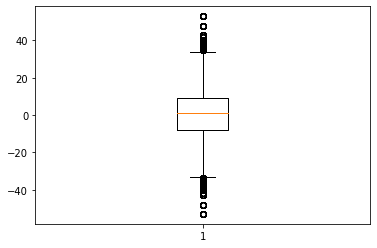

In [12]:
# FINAL_MARGIN: za koliko bodova je pobijedio ili izgubio tim igrača 
plt.boxplot(dataset.FINAL_MARGIN)
plt.show()

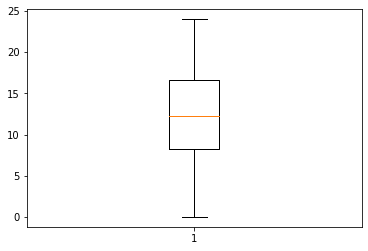

In [13]:
# SHOT_CLOCK: vrijeme pucanja u koš (unutar 24 sekunde napada)
plt.boxplot(dataset.SHOT_CLOCK)
plt.show()

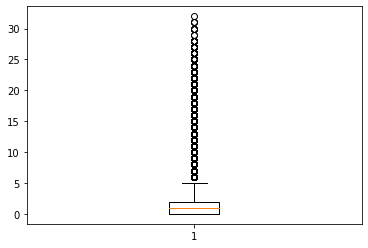

In [14]:
# DRIBBLES: broj driblanja prije pucanja u koš
plt.boxplot(dataset.DRIBBLES)
plt.show()

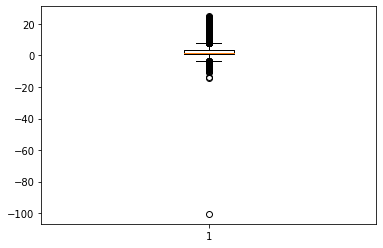

In [15]:
# TOUCH_TIME: vrijeme držanja lopte prije pucanja u koš
plt.boxplot(dataset.TOUCH_TIME)
plt.show()

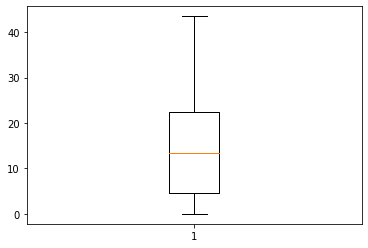

In [16]:
# SHOT_DIST: udaljenost s koje se igrač pucao u koš
plt.boxplot(dataset.SHOT_DIST)
plt.show()

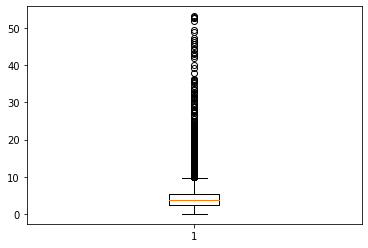

In [17]:
# CLOSE_DEF_DIST: udaljenost najbližeg igrača protivničkog tima
plt.boxplot(dataset.CLOSE_DEF_DIST)
plt.show()

Za sada nećemo ništa poduzimati u vezi stršećih vrijednosti zato što ih autor rada uopće ne spominje.

## 2.5 Vizualizacija podataka

Kategoričke podatke ćemo prikazati pomoću pie chart-a.

Podjednak je broj utakmica u kojima igrač koji je pucao u koš igra home ili away:

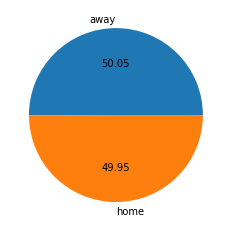

In [18]:
count_per_location = dataset.groupby('LOCATION').count().loc[:,'GAME_ID'].values
location_name = dataset.groupby('LOCATION').count().index.values

location_full_name = []
for one in location_name:
    if one == 'A':
        location_full_name.append('away')
    else:
        location_full_name.append('home')

plt.pie(count_per_location, labels=location_full_name, autopct='%.2f')
plt.show()

Podjednak je broj utakmica u kojima je tim igrača koji je pucao u koš pobijedio ili izgubio:

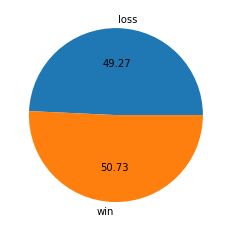

In [19]:
count_per_win = dataset.groupby('W').count().loc[:,'GAME_ID'].values
win_name = dataset.groupby('W').count().index.values

win_full_name = []
for one in win_name:
    if one == 'L':
        win_full_name.append('loss')
    else:
        win_full_name.append('win')

plt.pie(count_per_win, labels=win_full_name, autopct='%.2f')
plt.show()

Značajke SHOT_RESULT i FGM zapravo predstavljaju iste podatke koji su označeni na drugačiji način. Veći je broj pogodaka koji su neuspješni:

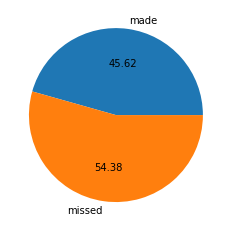

In [20]:
count_per_result = dataset.groupby('SHOT_RESULT').count().loc[:,'GAME_ID'].values
result_name = dataset.groupby('SHOT_RESULT').count().index.values

plt.pie(count_per_result, labels=result_name, autopct='%.2f')
plt.show()

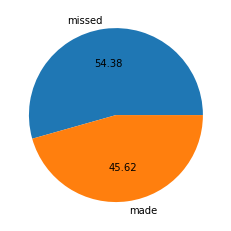

In [21]:
count_per_goal = dataset.groupby('FGM').count().loc[:,'GAME_ID'].values
goal_name = dataset.groupby('FGM').count().index.values

goal_full_name = []
for one in goal_name:
    if one == 0:
        goal_full_name.append('missed')
    else:
        goal_full_name.append('made')

plt.pie(count_per_goal, labels=goal_full_name, autopct='%.2f')
plt.show()

Većina podataka je zabilježena je za četvrtine utakmice, a manje od 1% podataka se odnosi na produžetke:

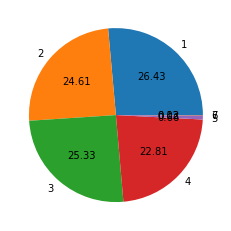

In [22]:
count_per_period = dataset.groupby('PERIOD').count().loc[:,'GAME_ID'].values
period_name = dataset.groupby('PERIOD').count().index.values

plt.pie(count_per_period, labels=period_name, autopct='%.2f')
plt.show()

Većina zabilježenih pogodaka su dvice:

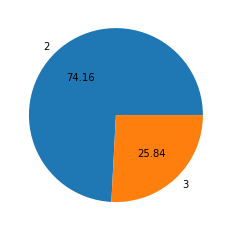

In [23]:
count_per_points_type = dataset.groupby('PTS_TYPE').count().loc[:,'GAME_ID'].values
points_type_name = dataset.groupby('PTS_TYPE').count().index.values

plt.pie(count_per_points_type, labels=points_type_name, autopct='%.2f')
plt.show()

Na prethodnim grafovima prikazano je kako je 54.38% pogodaka bilo neuspješno. To odogovara pogodcima kojima je dodijeljeno nula bodova:

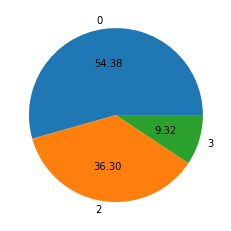

In [24]:
count_per_points = dataset.groupby('PTS').count().loc[:,'GAME_ID'].values
points_name = dataset.groupby('PTS').count().index.values

plt.pie(count_per_points, labels=points_name, autopct='%.2f')
plt.show()

# 3. Priprema dataset-a 

Autor članka navodi kako je za algoritme koristio kombinacije sljedećih značajki: LOCATION, W, FINAL_MARGIN, SHOT_NUMBER, PERIOD, GAME_CLOCK, SHOT_CLOCK, DRIBBLES, TOUCH_TIME, SHOT_DIST, PTS_TYPE, CLOSEST_DEFENDER, CLOSEST_DEFENDER_PLAYER_ID, CLOSE_DEF_DIST, FGM, PTS, player_name, player_id. <br /> 

Dakle možemo odmah iz dataset-a izbaciti značajke GAME_ID i MATCHUP.

In [25]:
dataset.drop(('GAME_ID'), axis=1, inplace=True)
dataset.drop(('MATCHUP'), axis=1, inplace=True)

<br />
Značajka TOUCH_TIME ne bi smjela biti negativna pa ćemo pretpostaviti da su redovi dataset-a s negativnom vrijednosti te značajke pogrešno uneseni. Zbog toga ćemo ih ukloniti iz dataset-a.

In [26]:
indexNames = dataset[dataset['TOUCH_TIME'] < 0].index
dataset.drop(indexNames , inplace=True)

Nakon izbacivanja negativnih vrijednosti, minimalna vrijednost značajke TOUCH_TIME je 0:

In [27]:
dataset['TOUCH_TIME'].describe().min()

0.0

<br />
Značajke FGM (field goals made) i PTS (points made) su savršeni prediktori uspješnosti pogotka. Nema smisla raditi predikciju pogotka na temelju informacije o uspješnosti pogotka i broju ostvarenih bodova. Zbog toga ćemo ih izbaciti iz dataset-a:

In [28]:
dataset.drop(('FGM'), axis=1, inplace=True)
dataset.drop(('PTS'), axis=1, inplace=True)

In [29]:
dataset.shape

(122203, 17)

<br />
Značajka GAME_CLOCK je tipa time string. Potrebno ju je pretvoriti u sekunde:

In [30]:
dataset['GAME_CLOCK'] = dataset['GAME_CLOCK'].apply(lambda x: float(x.split(':')[0])*60 + float(x.split(':')[1]))

In [31]:
print(dataset['GAME_CLOCK'])

0          69.0
1          14.0
3         707.0
4         634.0
5         495.0
          ...  
128063    305.0
128064    112.0
128065    688.0
128066    670.0
128067    157.0
Name: GAME_CLOCK, Length: 122203, dtype: float64


<br />
Kategoričke značajke LOCATION i W imaju 2 kategorije. Kodirat ćemo te dvije pomoću brojevnih vrijednosti. Značajka LOCATION umjesto vrijednosti H imat će vrijednost 1, a umjesto vrijednosti A imat će vrijednost 0. Značajka W umjesto vrijednosti W imat će vrijednost 1, a umjesto vrijednosti L imat će vrijednost 0.

In [32]:
dataset['LOCATION'] = dataset['LOCATION'].apply(lambda x: 1 if x == 'H' else 0)
dataset['W'] = dataset['W'].apply(lambda x: 1 if x == 'W' else 0)

<br />
Kategoričke značajke koje su označene znakovnim vrijednostima potrebno je označiti brojevnim vrijednostima. To uključuje značajke CLOSEST_DEFENDER i player_name.

In [33]:
dataset['CLOSEST_DEFENDER'] = dataset['CLOSEST_DEFENDER'].astype('category')
dataset['player_name'] = dataset['player_name'].astype('category')

cat_columns = dataset.select_dtypes(['category']).columns

dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)

## 3.1 Priprema dataset-a za logističku regresiju, SVM i neuralne mreže

Maknut ćemo kategoričke značajke koje imaju više od dvije kategorije. To uključuje značajke SHOT_NUMBER, CLOSEST_DEFENDER, CLOSEST_DEFENDER_PLAYER_ID, player_name i player_id. Kada bi kategorije navedenih značajki zamijenili s brojevnim vrijednostima, one ne bi sadržavale inicijalno značenje pa bi 'zbunile' model. 

In [34]:
dataset_lr_svm_nm = dataset.copy()

drop_list = ['SHOT_NUMBER', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name', 'player_id']

for one in drop_list:
    dataset_lr_svm_nm.drop((one), axis=1, inplace=True)

In [35]:
dataset_lr_svm_nm.shape

(122203, 12)

<br />
Također ćemo ukloniti kategoričku značajku PERIOD i značajku GAME_CLOCK, a umjesto nje ćemo dodati novu značajku TOTAL_GAME_TIME koja će kombinirati te dvije značajke zajedno.

In [36]:
dataset_lr_svm_nm['TOTAL_GAME_TIME'] = dataset_lr_svm_nm['PERIOD'].apply(lambda x: (float(x)-1)*12*60 if x < 5 else 4*12*60 + (float(x) - 5) * 5 * 60) + dataset_lr_svm_nm['GAME_CLOCK']

dataset_lr_svm_nm.drop(('PERIOD'), axis=1, inplace=True)
dataset_lr_svm_nm.drop(('GAME_CLOCK'), axis=1, inplace=True)

<br />
Potrebno je normalizirati kontinuirane značajke FINAL_MARGIN, TOTAL_GAME_TIME, SHOT_CLOCK, DRIBBLES, TOUCH_TIME, SHOT_DIST, CLOSE_DEF_DIST.

In [37]:
normalize_list = ['FINAL_MARGIN', 'TOTAL_GAME_TIME', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']

for one in normalize_list:
    dataset_lr_svm_nm[one] = preprocessing.normalize(np.array([dataset_lr_svm_nm[one]]))[0]

## 3.2 Priprema dataset-a za naivni Bayesov postupak

In [38]:
dataset_nb = dataset.copy()

Potrebno je sažeti kontinuirane značajke FINAL_MARGIN, GAME_CLOCK, SHOT_CLOCK, DRIBBLES, TOUCH_TIME, SHOT_DIST i CLOSE_DEF_DIST u četiri kategorije. μ označava srednju vrijednost značajke, x označava vrijednost značajke, a σ standardnu devijaciju.

x < μ - σ <br />
μ > x > μ - σ <br />
μ < x < μ + σ <br />
x > μ + σ <br />

In [39]:
def binning(column):
    
    if dataset_nb[column].min() < dataset_nb[column].mean() - dataset_nb[column].std():
        bins = [dataset_nb[column].min(), dataset_nb[column].mean() - dataset_nb[column].std(), dataset_nb[column].mean(), dataset_nb[column].mean() + dataset_nb[column].std(), dataset_nb[column].max()]
        labels = [0, 1, 2, 3]
    else:
        bins = [dataset_nb[column].mean() - dataset_nb[column].std(), dataset_nb[column].mean(), dataset_nb[column].mean() + dataset_nb[column].std(), dataset_nb[column].max()]
        labels = [1, 2, 3]

    dataset_nb[column] = pd.cut(dataset_nb[column], bins=bins, labels=labels, include_lowest=True)

In [40]:
binning_list = ['FINAL_MARGIN', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']

for one in binning_list:
    binning(one)

## 3.3 Priprema dataset-a za boosting

Za konkretnu implementaciju boosting algoritma kojeg ćemo koristiti oznake klasa moraju biti brojevne vrijednosti.

In [41]:
dataset_b = dataset.copy()

dataset_b['SHOT_RESULT'] = dataset_b['SHOT_RESULT'].apply(lambda x: 1 if x == 'made' else 0)

# 4. Podjela dataset-a na skup za treniranje i skup za testiranje

Dataset je potrebno podijeliti na skup za treniranje i skup za testiranje. Skupu za treniranje sastojat će se od 95% podataka iz dataset-a, a skup za testiranje od 5% podataka. Odabrani omjer koristi se kako bi algoritmi mogli koristiti što više podataka za treniranje.

In [42]:
dataset_train, dataset_test, result_train, result_test = train_test_split(dataset.drop('SHOT_RESULT', axis=1), dataset['SHOT_RESULT'], test_size=0.05)
dataset_lr_svm_nm_train, dataset_lr_svm_nm_test, result_lr_svm_nm_train, result_lr_svm_nm_test = train_test_split(dataset_lr_svm_nm.drop('SHOT_RESULT', axis=1), dataset_lr_svm_nm['SHOT_RESULT'], test_size=0.05)
dataset_nb_train, dataset_nb_test, result_nb_train, result_nb_test = train_test_split(dataset_nb.drop('SHOT_RESULT', axis=1), dataset_nb['SHOT_RESULT'], test_size=0.05)
dataset_b_train, dataset_b_test, result_b_train, result_b_test = train_test_split(dataset_b.drop('SHOT_RESULT', axis=1), dataset_b['SHOT_RESULT'], test_size=0.05)

# 5. Implementacija
Za implementaciju svakog algoritma koristit ćemo javno dostupne biblioteke pomoću kojih ćemo kreirati model koji ćemo zatim trenirati. Nakon treniranja napravit ćemo predikcije te izračunati njihovu točnost i matricu pogreške. Točnost se računa kao omjer broja točnih predikcija i broja svih predikcija. Matrica pogreške na pregledan način prikazuje broj ispravno klasificiranih primjera, broj lažno pozitivnih i broj lažno negativnih primjera. 

## 5.1 Logistička regresija

Za implementaciju algoritma logističke regresije koristit ćemo razred SGDClassifier iz modula sklearn.linear_model. Koristit ćemo L2-regularizaciju s faktorom regularizacije 0.0001. Brzinu učenja postavit ćemo na vrijednost 10.

Koristit ćemo značajke:

In [43]:
dataset_lr_svm_nm_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST',
       'TOTAL_GAME_TIME'], dtype=object)

In [44]:
log_model = SGDClassifier(loss='log', eta0=10, learning_rate='constant', alpha=0.0001, penalty='l2')

log_model.fit(dataset_lr_svm_nm_train, result_lr_svm_nm_train)

SGDClassifier(eta0=10, learning_rate='constant', loss='log')

In [45]:
predictions_lr_train = log_model.predict(dataset_lr_svm_nm_train)
predictions_lr_test = log_model.predict(dataset_lr_svm_nm_test)

In [46]:
accuracy_lr_train = accuracy_score(result_lr_svm_nm_train, predictions_lr_train)
accuracy_lr_test = accuracy_score(result_lr_svm_nm_test, predictions_lr_test)

In [47]:
matrix_lr_train = pd.crosstab(result_lr_svm_nm_train, predictions_lr_train, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_lr_test = pd.crosstab(result_lr_svm_nm_test, predictions_lr_test, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

## 5.2 SVM

Za implementaciju SVM-a koristit ćemo razred LinearSVC iz modula sklearn.svm.

Koristit ćemo značajke:

In [48]:
dataset_lr_svm_nm_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST',
       'TOTAL_GAME_TIME'], dtype=object)

In [49]:
svm_model = LinearSVC()
svm_model.fit(dataset_lr_svm_nm_train, result_lr_svm_nm_train)

LinearSVC()

In [50]:
predictions_svm_train = svm_model.predict(dataset_lr_svm_nm_train)
predictions_svm_test = svm_model.predict(dataset_lr_svm_nm_test)

In [51]:
accuracy_svm_train = accuracy_score(result_lr_svm_nm_train, predictions_svm_train)
accuracy_svm_test = accuracy_score(result_lr_svm_nm_test, predictions_svm_test)

In [52]:
matrix_svm_train = pd.crosstab(result_lr_svm_nm_train, predictions_svm_train, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_svm_test = pd.crosstab(result_lr_svm_nm_test, predictions_svm_test, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

## 5.3 Neuralne mreže

Za implementaciju neuralne mreže koristit ćemo razred MLPClassifier iz modula sklearn.neural_network. Trenirat ćemo dvije mreže s različitom aktivacijskom funkcijom skrivenog sloja. Ostali parametri bit će isti za obje mreže: mreža s jednim skrivenim slojem s 50 neurona, batch size 1000, brzina učenja 5 te se koristi L2-regularizacija s faktorom regularizacije 0.0001.

Koristit ćemo značajke:

In [53]:
dataset_lr_svm_nm_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST',
       'TOTAL_GAME_TIME'], dtype=object)

Prva neuralna mreža koristi sigmoidalnu aktivacijsku funkciju u skrivenom sloju.

In [54]:
nm_model_1 = MLPClassifier(hidden_layer_sizes=(50,), activation='logistic', batch_size=1000, learning_rate='constant', learning_rate_init=5, alpha=0.0001)
nm_model_1.fit(dataset_lr_svm_nm_train, result_lr_svm_nm_train)

MLPClassifier(activation='logistic', batch_size=1000, hidden_layer_sizes=(50,),
              learning_rate_init=5)

In [55]:
predictions_nm_train_1 = nm_model_1.predict(dataset_lr_svm_nm_train)
predictions_nm_test_1 = nm_model_1.predict(dataset_lr_svm_nm_test)

In [56]:
accuracy_nm_train_1 = accuracy_score(result_lr_svm_nm_train, predictions_nm_train_1)
accuracy_nm_test_1 = accuracy_score(result_lr_svm_nm_test, predictions_nm_test_1)

In [57]:
matrix_nm_train_1 = pd.crosstab(result_lr_svm_nm_train, predictions_nm_train_1, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_nm_test_1 = pd.crosstab(result_lr_svm_nm_test, predictions_nm_test_1, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

Druga neuralna mreža koristi ReLU aktivacijsku funkciju u skrivenom sloju.

In [58]:
nm_model_2 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', batch_size=1000, learning_rate='constant', learning_rate_init=5, alpha=0.0001)
nm_model_2.fit(dataset_lr_svm_nm_train, result_lr_svm_nm_train)

MLPClassifier(batch_size=1000, hidden_layer_sizes=(50,), learning_rate_init=5)

In [59]:
predictions_nm_train_2 = nm_model_2.predict(dataset_lr_svm_nm_train)
predictions_nm_test_2 = nm_model_2.predict(dataset_lr_svm_nm_test)

In [60]:
accuracy_nm_train_2 = accuracy_score(result_lr_svm_nm_train, predictions_nm_train_2)
accuracy_nm_test_2 = accuracy_score(result_lr_svm_nm_test, predictions_nm_test_2)

In [61]:
matrix_nm_train_2 = pd.crosstab(result_lr_svm_nm_train, predictions_nm_train_2, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_nm_test_2 = pd.crosstab(result_lr_svm_nm_test, predictions_nm_test_2, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

## 5.4 Naivni Bayesov postupak

Za implementaciju naivnog Bayesovog postupka koristit ćemo razred MultinomialNB iz modula sklearn.naive_bayes.

Koristit ćemo značajke:

In [62]:
dataset_nb_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD',
       'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST',
       'PTS_TYPE', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'player_name', 'player_id'], dtype=object)

In [63]:
nb_model = MultinomialNB()
nb_model.fit(dataset_nb_train, result_nb_train)

MultinomialNB()

In [64]:
predictions_nb_train = nb_model.predict(dataset_nb_train)
predictions_nb_test = nb_model.predict(dataset_nb_test)

In [65]:
accuracy_nb_train = accuracy_score(result_nb_train, predictions_nb_train)
accuracy_nb_test = accuracy_score(result_nb_test, predictions_nb_test)

In [66]:
matrix_nb_train = pd.crosstab(result_nb_train, predictions_nb_train, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_nb_test = pd.crosstab(result_nb_test, predictions_nb_test, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

## 5.5 Slučajne šume

Za implementaciju algoritma slučajnih šuma koristit ćemo razred RandomForestClassifier iz modula sklearn.ensemble. Za treniranje će se koristiti 80 stabala i minimalno 50 listova na svakom stablu.

Koristit ćemo značajke:

In [67]:
dataset_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD',
       'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST',
       'PTS_TYPE', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'player_name', 'player_id'], dtype=object)

In [68]:
rf_model = RandomForestClassifier(n_estimators=80, min_samples_leaf=50)
rf_model.fit(dataset_train, result_train)

RandomForestClassifier(min_samples_leaf=50, n_estimators=80)

In [69]:
predictions_rf_train = rf_model.predict(dataset_train)
predictions_rf_test = rf_model.predict(dataset_test)

In [70]:
accuracy_rf_train = accuracy_score(result_train, predictions_rf_train)
accuracy_rf_test = accuracy_score(result_test, predictions_rf_test)

In [71]:
matrix_rf_train = pd.crosstab(result_train, predictions_rf_train, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_rf_test = pd.crosstab(result_test, predictions_rf_test, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

## 5.6 Boosting

Za implementaciju boostinga koristit ćemo razred XGBClassifier iz modula xgboost. Kao parametre postavljamo: 1 procjenitelj, brzinu učenja 0.0001, maksimalnu dubinu 3 te minimalnu vrijednost čvora djeteta 0.0001.

Koristit ćemo značajke:

In [72]:
dataset_b_train.columns.values

array(['LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD',
       'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST',
       'PTS_TYPE', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'player_name', 'player_id'], dtype=object)

In [73]:
b_model = XGBClassifier(n_estimators=1, max_depth=3, learning_rate=0.0001, min_child_weight=0.0001, use_label_encoder=False)
b_model.fit(dataset_b_train, result_b_train)

[23:50:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0001,
              max_delta_step=0, max_depth=3, min_child_weight=0.0001,
              missing=nan, monotone_constraints='()', n_estimators=1, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [74]:
predictions_b_train = b_model.predict(dataset_b_train)
predictions_b_test = b_model.predict(dataset_b_test)

In [75]:
accuracy_b_train = accuracy_score(result_b_train, predictions_b_train)
accuracy_b_test = accuracy_score(result_b_test, predictions_b_test)

In [76]:
matrix_b_train = pd.crosstab(result_b_train, predictions_b_train, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])
matrix_b_test = pd.crosstab(result_b_test, predictions_b_test, rownames=['STVARNE VRIJEDNOSTI'], colnames=['PREDIKCIJE'])

# 6. Rezultati

## 6.1 Točnost

Za evaluaciju rezultata koristit ćemo točnost koja se računa tako da se broj točnih predikcija podijeli s ukupnim brojem predikcija. Točnost je izračunata u prethodnim koracima pomoću metode accuracy_score iz modula sklearn.metrics. Opisani način evaluacije rezultata koristit ćemo kako bi mogli usporediti rezultate s rezultatima iz članka.

Autor članka navodi sljedeće rezultate za točnost na skupu za testiranje:
- 59% za logističku regresiju
- 55% za SVM
- 55% za neuralnu mrežu sa sigmoidalnom aktivacijskom funkcijom u skrivenom sloju
- 55% za neuralnu mrežu sa ReLU aktivacijskom funkcijom u skrivenom sloju
- 54% za naivni Bayesov postupak
- 61% za algoritam slučajnih šuma
- 68% za boosting

Iako je korišten jednak postupak pripreme dataset-a za treniranje, nije dobivena jednaka točnost za svaki od algoritama kao u članku čije smo rezultate trebali replicirati. <br /> Boosting i algoritam slučajnih šuma su se pokazali kao najuspješniji algoritmi s podjednakom točnosti na skupu za testiranje, a u članku se navodi kako je najbolji algoritam boosting s točnosti od 68%.

In [77]:
d = {'logistička regresija': [accuracy_lr_train, accuracy_lr_test],
'SVM': [accuracy_svm_train, accuracy_svm_test],
'neuralna mreža 1': [accuracy_nm_train_1, accuracy_nm_test_1],
'neuralna mreža 2': [accuracy_nm_train_2, accuracy_nm_test_2],
'bayes': [accuracy_nb_train, accuracy_nb_test],
'slučajne šume': [accuracy_rf_train, accuracy_rf_test],
'boosting': [accuracy_b_train, accuracy_b_test]   }

print ("{:<25} {:<25} {:<10}".format('ALGORITAM','TOČNOST (učenje)','TOČNOST (testiranje)'))
print('------------------------------------------------------------------------')

for k, v in d.items():
    acc_train, acc_test = v
    print ("{:<25} {:<25} {:<10}".format(k, acc_train, acc_test))

ALGORITAM                 TOČNOST (učenje)          TOČNOST (testiranje)
------------------------------------------------------------------------
logistička regresija      0.5097164317954725        0.498772704958272
SVM                       0.5895496675050822        0.5835378825069547
neuralna mreža 1          0.5433966164765875        0.5455735558828342
neuralna mreža 2          0.45660338352341245       0.45442644411716576
bayes                     0.5278313751162871        0.5305187367043037
slučajne šume             0.6574096406298453        0.6092292587137947
boosting                  0.6095768872962822        0.607592865324824


## 6.2 Matrica pogrešaka

Za svaki algoritam ćemo prikazati matricu pogrešaka koja je izračunata u prethodnim koracima pomoću metode crosstab iz modula pandas.

### 6.2.1 Matrica pogreške za logističku regresiju:

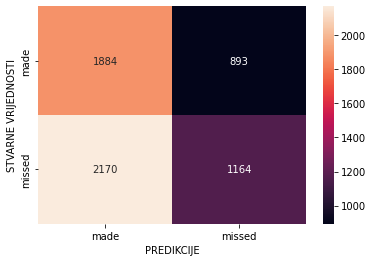

In [78]:
sn.heatmap(matrix_lr_test, annot=True, fmt='g')
plt.show()

### 6.2.2 Matrica pogreške za SVM:

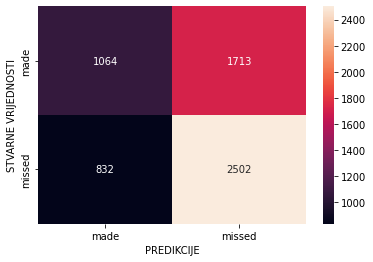

In [79]:
sn.heatmap(matrix_svm_test, annot=True, fmt='g')
plt.show()

### 6.2.3 Matrica pogreške za neuralnu mrežu koja koristi sigmoidalnu aktivacijsku funkciju u skrivenom sloju:

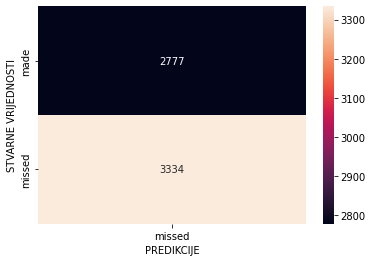

In [80]:
sn.heatmap(matrix_nm_test_1, annot=True, fmt='g')
plt.show()

### 6.2.4 Matrica pogreške za neuralnu mrežu koja koristi ReLU aktivacijsku funkciju u skrivenom sloju:

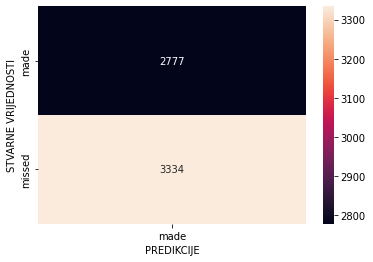

In [81]:
sn.heatmap(matrix_nm_test_2, annot=True, fmt='g')
plt.show()

### 6.2.5 Matrica pogreške za naivni Bayesov postupak:

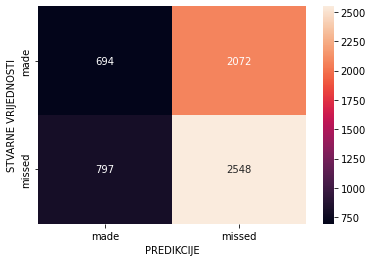

In [82]:
sn.heatmap(matrix_nb_test, annot=True, fmt='g')
plt.show()

### 6.2.6 Matrica pogreške za algoritam slučajnih šuma:

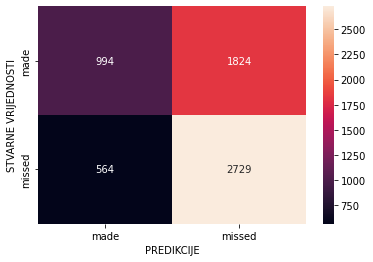

In [83]:
sn.heatmap(matrix_rf_test, annot=True, fmt='g')
plt.show()

### 6.2.7 Matrica pogreške za boosting algoritam:

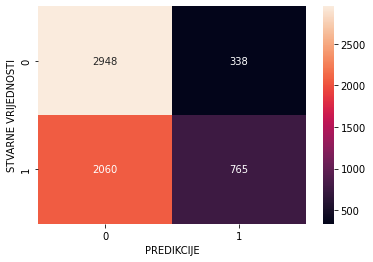

In [84]:
sn.heatmap(matrix_b_test, annot=True, fmt='g')
plt.show()